## Data Pre-Processing and Feature Engineering

From the EDA some information related to the nature of the data was gather, such as:

- The presence of missing values in the actual times.  
actual_start_time_picking: 23378  
actual_end_time_picking: 37408

- No duplicates where found.

- There are extreme values (outliers) that could significantly skew the analysis.

## 1. Import Data and Required Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

os.chdir("../")
%pwd

'c:\\Users\\anfe1\\OneDrive\\Escritorio\\Instaleap\\Instamarket'

#### Import the CSV Data as Pandas DataFrame

In [3]:
df = pd.read_csv('artifacts/data.csv')

# Converting time_picking's to datetime DType
datetime_cols = ["actual_start_time_picking",
                 "actual_end_time_picking",
                 "optimal_start_time_picking",
                 "optimal_end_time_picking"]
df[datetime_cols] = df[datetime_cols].apply(pd.to_datetime, format="mixed")


As the "job_id" column is just a label for the order could be dropped as it does not give any additonal information

In [4]:
df.drop(columns="job_id", axis=1, inplace=True)

## 2. Actions to perform

- Handling missing values
- Handling outliers

### 2.1 Handling Missing values

In [5]:
df.isna().sum()

store_id                          0
actual_start_time_picking     23378
actual_end_time_picking       37408
optimal_start_time_picking        0
optimal_end_time_picking          0
dtype: int64

In [6]:
print(df["actual_start_time_picking"].isna().sum()/df.shape[0]*100)
print(df["actual_end_time_picking"].isna().sum()/df.shape[0]*100)

# print(df[~df["actual_start_time_picking"].isna() & df["actual_end_time_picking"].isna()].shape[0]/df.shape[0]*100)

6.933964502657555
11.095292331055429


At first I will remove the rows with missing values assuming there where cancelled orders.

In [7]:
df.dropna(subset=['actual_start_time_picking', 'actual_end_time_picking'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299744 entries, 0 to 299743
Data columns (total 5 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   store_id                    299744 non-null  object             
 1   actual_start_time_picking   299744 non-null  datetime64[ns, UTC]
 2   actual_end_time_picking     299744 non-null  datetime64[ns, UTC]
 3   optimal_start_time_picking  299744 non-null  datetime64[ns, UTC]
 4   optimal_end_time_picking    299744 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](4), object(1)
memory usage: 11.4+ MB


So, there reamins 299744 rows to work with. It's still very good amount of data representing the 88.9% of the original data.

### 2.2 Adding columns for analysis 

Time analysis columns
- actual_total_time
- optimal_total_time

Efficiency analysis columns
- start_delay
- end_delay
- PTP (Picking Time Percentage)

In [8]:
time_analysis_cols = ["actual_total_time",
                      "optimal_total_time",
                      "diff_actual_optimal_time"]

efficiency_cols = ["start_delay",
                   "end_delay",
                   "PTP"]

df["actual_total_time"] = (df["actual_end_time_picking"] - df["actual_start_time_picking"]).dt.total_seconds() / 60.0
df["optimal_total_time"] = (df["optimal_end_time_picking"] - df["optimal_start_time_picking"]).dt.total_seconds() / 60.0
df["diff_actual_optimal_time"] = df["actual_total_time"] - df["optimal_total_time"]

df["start_delay"] = (df["actual_start_time_picking"] - df["optimal_start_time_picking"]).dt.total_seconds() / 60.0
df["end_delay"] = (df["actual_end_time_picking"] - df["optimal_end_time_picking"]).dt.total_seconds() / 60.0

df["PTP"] = df["actual_total_time"]/df["optimal_total_time"]

df.count()

store_id                      299744
actual_start_time_picking     299744
actual_end_time_picking       299744
optimal_start_time_picking    299744
optimal_end_time_picking      299744
actual_total_time             299744
optimal_total_time            299744
diff_actual_optimal_time      299744
start_delay                   299744
end_delay                     299744
PTP                           299744
dtype: int64

### 2.3 Handling Outliers

From the EDA it was seen some extreme values that could significantly skew the results.  
Z-score will be used. Scores beyond the threshold (-3,3) will be identified as outliers.  
  
On first intance the outliers will be removed.

In [9]:
cols_to_normalize = [*time_analysis_cols,*efficiency_cols]

for col in cols_to_normalize:
    col_zscore = col + '_zscore'
    df[col_zscore] = (df[col] - df[col].mean())/df[col].std(ddof=0)

In [10]:
# zcore_cols  =  [col+ '_zscore' for col in ["actual_total_time","diff_actual_optimal_time",*efficiency_cols]]
zcore_cols  =  [col+ '_zscore' for col in cols_to_normalize]
filters = [(df[col]>-3) & (df[col]<3) for col in zcore_cols]

df_clean = df[np.logical_and.reduce(filters)]

In [11]:
df_clean.nunique()

store_id                              740
actual_start_time_picking          236020
actual_end_time_picking            288638
optimal_start_time_picking          11912
optimal_end_time_picking            11731
actual_total_time                  279599
optimal_total_time                     98
diff_actual_optimal_time           284122
start_delay                        219161
end_delay                          283379
PTP                                286024
actual_total_time_zscore           279599
optimal_total_time_zscore              98
diff_actual_optimal_time_zscore    282082
start_delay_zscore                 219161
end_delay_zscore                   283379
PTP_zscore                         285457
dtype: int64

In [12]:
df_clean.drop(columns=["actual_total_time","diff_actual_optimal_time","PTP",*zcore_cols], inplace=True)

In [13]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 288715 entries, 0 to 299743
Data columns (total 8 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   store_id                    288715 non-null  object             
 1   actual_start_time_picking   288715 non-null  datetime64[ns, UTC]
 2   actual_end_time_picking     288715 non-null  datetime64[ns, UTC]
 3   optimal_start_time_picking  288715 non-null  datetime64[ns, UTC]
 4   optimal_end_time_picking    288715 non-null  datetime64[ns, UTC]
 5   optimal_total_time          288715 non-null  float64            
 6   start_delay                 288715 non-null  float64            
 7   end_delay                   288715 non-null  float64            
dtypes: datetime64[ns, UTC](4), float64(3), object(1)
memory usage: 19.8+ MB


In [15]:
# df_clean.to_csv("artifacts/data_clean.csv", index=False, header=True)

## 3. Visualizing pre-process data

<Axes: xlabel='diff_actual_optimal_time', ylabel='Count'>

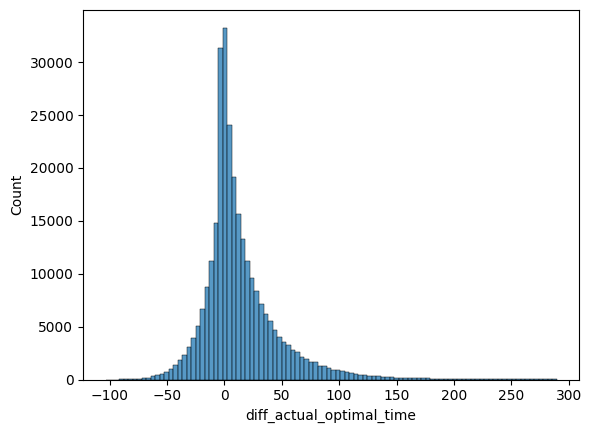

In [ ]:
sb.histplot(data=df_clean,x='diff_actual_optimal_time', bins=100)

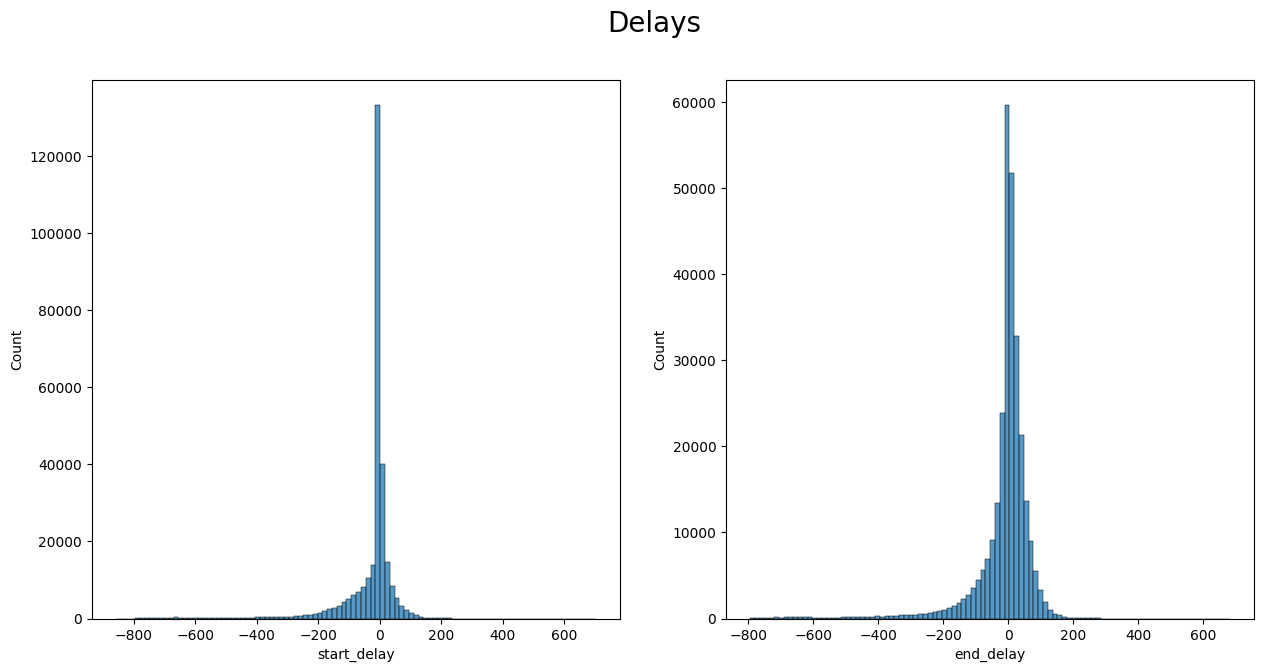

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(121)
sb.histplot(data=df_clean,x='start_delay', bins=100)
plt.subplot(122)
sb.histplot(data=df_clean,x='end_delay', bins=100)
fig.suptitle("Delays", fontsize=20)
plt.show()